<a href="https://colab.research.google.com/github/maarongross/apriltag-imgs/blob/master/AprilTags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pip._internal import main as pipmain
pipmain(['install', 'package-name'])

In [13]:
import cv2
from google.colab.patches import cv2_imshow
import apriltag

In [134]:
img = cv2.imread('/content/drive/MyDrive/(1) UCSD/(6) Fall 2022/MAE-148/AprilTags/apriltag-imgs-master/apriltag-imgs-master/tag16h5/tag16_05_00020.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img,(220,220), interpolation = cv2.INTER_AREA)

options = apriltag.DetectorOptions(families="tag16h5")
detector = apriltag.Detector(options)
result = detector.detect(img)

img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

20
[INFO] tag ID: 20


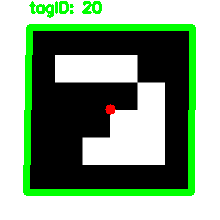

In [135]:
for r in result:

  (A,B,C,D) = r.corners 
  corner_B = (int(B[0]), int(B[1]))
  corner_C = (int(C[0]), int(C[1]))
  corner_D = (int(D[0]), int(D[1]))
  corner_A = (int(A[0]), int(A[1]))
  
  cv2.line(img, corner_A, corner_B, (0,255,0), 5)
  cv2.line(img, corner_B, corner_C, (0,255,0), 5)
  cv2.line(img, corner_C, corner_D, (0,255,0), 5)
  cv2.line(img, corner_D, corner_A, (0,255,0), 5)

  (cX,cY) = (int(r.center[0]), int(r.center[1]))
  cv2.circle(img,(cX,cY), 5, (0, 0, 255), -1)

  tagFamily = r.tag_family.decode("utf-8")
  tagID = str(r.tag_id)
  print(tagID)
  cv2.putText(img, "tagID: " + tagID, (corner_A[0], corner_A[1] - 15),
              cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
  
  print("[INFO] tag ID: {}".format(tagID))

cv2_imshow(img)

In [136]:
checkPointInfo = {10 : "Velocity = 10 \n Checkpoint #1",
                  20 : "Velocity = 50 \n Checkpoint #2",
                  30 : "Velocity = 10 \n Checkpoint #3"}

print(checkPointInfo[int(tagID)])

Velocity = 50 
 Checkpoint #2
